# Amortised Bayesian Inference in Hierarhical Dynamical Systems

In this notebook, we examine the embedding of a stochastic autoencoder with a reparametrized variational inference distribution -- a variational autoencoder -- within the settings of dynamical systems for efficient amortised inference of parameters and unobserved states. Initially, we exploit a generative process to capture the uncertainty within the model and, concomitantly, instantiate an inferential procedure to delineate the aleatory uncertainty within the measurements. Subsequently, we endow the inference distribution with a mean-field approximation and further design a neural network to estimate its parameters, which amortizes the computations through the sharing of statistical strength between the instances in the data set. 

We start, however, with an exposition of the model's architecture; a reasonably self-contained approach is contained in the [slides](./slides). With this objective, notice that, in a hierarchical dynamical system, there are multiple species interacting with distinct environments; these environments, moreover, are stratifiable in distinct (and, as we will verify, compositional) groups, which, then, characterize a population. Thus, each evironments enforms a parametrizable dynamical system; nevertheless, the parameters may, or may not, be shared within the same group or between distinct population. Henceforth, we will identify its parameters as *species*, whereas its distinct instantiations in different branchs of the hierarchy will be characterized as *components*; equivalently, a component is an instance of a species in a prespecified environment. 

Crucially, in a Bayesian framework, the postulation of a parameter space is equivalent to the identification of a latent space in which the data is properly, although lossy, encoded; hence, we write henceforth $\mathbf{Z}$ for the model's parameters, which are compartimentalized as 

\begin{equation*} 
(\mathbf{z}_{I}, \mathbf{z}_{G}, \mathbf{z}_{P}) \in \mathbf{Z}, 
\end{equation*} 

for the individual, $\mathbf{z}_{I}$, collective, $\mathbf{z}_{G}$, and populational $\mathbf{z}_{P}$, attributes. In these settings, we generative process is as follows. In an initial moment, a latent variable is sampled from an (unknown) distribution, inducing particular strucutral boundaries for the dynamical system, whose realization is subjected to an observer and a noise process, culminating in the current observation. Explicitly, the succeeding algorithm identifies our generative process. 

+ $\mathbf{z} \sim \pi(\mathbf{z})$, 
+ $\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \mathbf{z})$, 
+ $\mathbf{X} = \textrm{Simulate}(\mathbf{f}, \mathbf{X}_{o})$ ($\mathbf{X}_{o}$ equals the initial state of the system), 
+ $M = \psi(\mathbf{X})$, the observer process, $\Sigma = \rho(\mathbf{X}, \mathbf{z})$, the noise process,  
+ $\mathbf{Y} \sim \pi(\mathbf{Y} | M, \Sigma)$; this comprises the observed data. 

Importantly, this model accounts concomitantly for white-box, in which a reasonable dynamical system $\mathbf{f}$ is prespecified by a human, and black-box, with the indexation of the model by a finite-dimensional parameter $\theta$, $\mathbf{f}_{\theta}$, and the succeeding inference on $\theta$ (jointly with $\mathbf{z}$), typically with a neural network. The noisy mappings, $\psi $ and $\rho$, in contrast, capture the partial observability constraints for this endeavor. Thus, this model is designed for inference on both *highly nonlinear* and *partially observable* dynamical systems, bestowing its amenability to multiple circumstances. 

Moreover, the generative process induces, by Bayes' rule, a posterior distribution on $\mathbf{Z}$; precisely, 

\begin{equation*} 
\pi(\mathbf{Z} | \mathbf{Y}) \propto f(\mathbf{Y} | \mathbf{Z}) \pi(\mathbf{Z}), 
\end{equation*} 

in which $f(\mathbf{Y} | \mathbf{Z})$ corresponds to the likelihood function underlying the mapping from the latent space, $\mathbf{Z}$, to the samples, $\mathbf{X}$. Nonetheless, this posterior distribution is in general analytically and computationally intractable; thus, we resort to the variational inference framework through a mean-field approximation and regard the inference as an optimization of a divergence measure between the variational approximation and the model's posterior distribution. More explicitly, we let 

\begin{equation*} 
\mathcal{Q} = \{q \colon \mathbf{Z} \rightarrow \mathbb{R}_{+} | q(\mathbf{Z}) = q_{\psi_{I}} (\mathbf{z}_{I}) q_{\psi_{G}} (\mathbf{z}_{G}) q_{\psi_{P}} (\mathbf{z}_{P})\}, 
\end{equation*}

with $\psi_{I}$, $\psi_{G}$ and $\psi_{P}$ as the variational parameters; nextly, $\psi = (\psi_{I}, \psi_{G}, \psi_{P})$. Then, we factor the data marginal log-likelihood as 

\begin{equation*} 
\log p(\mathbf{Y}) = KL(q(\cdot) || \pi( \cdot | \mathbf{Y})) + ELBO (q(\cdot), \pi(\cdot | \mathbf{Y}))
\end{equation*} 
 
(we write $KL$ for the Kullback-Leibler divergence; $ELBO$, in contrast, equals the *evidence lower bound*) and subsequently tackle the optimization 

\begin{equation*} 
(\hat{\psi_{I}}, \hat{\psi_{G}}, \hat{\psi_{P}}) = \textrm{argmin} \ ELBO(q(\cdot) | \pi(\cdot | \mathbf{Y})).  
\end{equation*} 

Circumstantially, we emphasize that, although we could compute, for each instance $\mathbf{Y}$ in the data set, an optimal parameter $\psi(\mathbf{Y})$ to attain the tighest evidence lower bound, this approach would not scale to massive data settings. Hence, we train a neural network [1] that estimates, for each observation, the optimal variational parameters; this approach, in which we share the data's statistical strength through a parametrized estimator, is called *amortized inference*. Particularly, the coupling between a reparametrized variational distribution with a stochastic variational inference characterizes the *variational autoencoders* framework. 

Alas, this description of the variational autoencoder architecture does not (explicitly) incorporate the hierarchical structure within the dynamical model. Nevertheless, a sensible data model could rectify this -- and it would not require further disruptions in the model's design. In this sense, we expose in the following a mathematical structure for the data which, on the one hand, is amenable to standard statistical approachs designed for relational databases and, on the other hand, is compatible with the *zero-shot learning* environment, in which the model is not constrained to the compartimentalization of the training data -- it consistently estimate the parameters for individuals equipped with previously unseen categorical attributes. 

In more detail, *each* datum equals a $M \times T$ matrix, in which $M$ corresponds to the quantity of (observed) states in $T$ different moments; a data set, then, comprises a finite collection of matrices, 

\begin{equation*} 
\{\mathbf{Y}^{(n)} \in \mathbb{R}^{M \times T} \colon n \in \{1, \dots, N\}\}, 
\end{equation*} 

with $N$ as data's length. Alternatively, we could exploit a scenario whose temporal ranges are different for each instance; the requirement consists in the design of an appropriate architecture for the amortized inference algorithm, which we will not examine. Furthermore, we attach to each $\mathbf{Y}^{(n)}$ a *group* $\mathbf{g}^{(n)}$, which summarizes the hierarchical structure within the dynamical system. Strucutrally, each group is identified as a composition of one-hot encoded shared components; thus, we are *compositionally stratifying the data*. Symbolically, suppose there are $S$ shared components and that each component $s$ attains $K_{s}$ distinct values; thus, we write 

\begin{equation*} 
\mathbf{g}^{(n)} = \begin{bmatrix} \mathbf{c}_{1}^{(n)}, \dots, \mathbf{c}_{S}^{(n)} \end{bmatrix}, 
\end{equation*} 

with $\mathbf{c}_{s}^{(n)} \in \mathbb{R}^{K_{s}}$ as a one-hot encoding vector -- it is a component of $\mathbb{R}^{K_{s}}$'s canonical basis. As an example, suppose that the component $\mathbf{c}_{s}$ is parametrized through a finite-dimensional parameter $\theta_{s} \in \mathbb{R}^{K_{s}}$; its instantiation, $\mathbf{c}_{s}^{(n)}$, thus, would be parametrized with 

\begin{equation*} 
(\mathbf{c}_{s}^{(n)})^{T} \theta_{s}. 
\end{equation*} 

In these episodes, we enable the model to estimate the behavior of an individual embedded with *any* composition of groups -- including those which are not contemplated in the training data; this attribute is called *zero-shot* learning. 

Alternatively, as Geoffrey Roeder appropriately writes, this data model incorporates concomitantly *repeated observations of groups* and *group stratification by composition*. Heuristically, this is equivalent to training a model which aims to capture the structural information within the hierarchically modelled dynamical system. Effectively, this entails the sensible introduction of the prior information within the inferential framework, which is crucial in high-dimensional settings due to the exponential increase in the data's sparsity. 

[1] The network's architecture is intricate, and its design is not crucial for this notebook's purpose; we do notice that the authors use a importance-weighted autoencoder with a doubly reparemetrized gradient estimators to unbiasedly estimate the parameters' gradient for the network's optimizer. 

# Example: estimate the protein concentration in cultures 

In this section, we will endeavor in the estimation of the protein's concentration in distinct culturues; these proteins are generated by genetically modified organisms and, thus, this inference is appropriate to ascertain that the genetic operation did culminate, with a reasonable uncertainty, in the expected cells' behavior. Importantly, this scenario induces, through the laws of chemical kinectics, a highly nonlinear dynamical system, which is exploited as a white-box model that supports the variational autoencoder, and partially observable scenario, as the quantities we objective to measure are compositionally, rather than independently, observed. Moreover, these settings are endowed with an hierarchical structure, as the different cultures are clustered through specific attributes which are controled by the chemist and, correlatively, there are global parameters, outlined by the experimental conditions, which equivariantly modify the behavior of each culture instance. 

With this goal, we will explore [Microsoft's implementation](https://github.com/microsoft/vi-hds) of this variational autoencoder designed for hierarchical dynamical systems.

In [36]:
%load_ext autoreload
import os 
import sys 
from IPython.display import display, clear_output, Image
module = "hds"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Clone the repository and appropriately settle the data
if not os.path.exists(module):
    !git clone https://github.com/tiagodsilva/$module 
    !mv $module/data . 

In [25]:
# Install packages; alternativaly, install the Conda environment 
# and access the Jupyter Notebook therein 
cmd = f"pip install -r {module}/requirements.txt"
!{cmd} 
clear_output() 

In [11]:
%autoreload 
import numpy as np 
import torch 
import yaml 
sys.path.append(module) 
from vihds.config import Config, Trainer 
from vihds.datasets import build_datasets 
from vihds.parameters import Parameters 
from vihds.training import Training 
from vihds.xval import XvalMerge 
from vihds.vae import build_model 

In [26]:
# Users' parameters 
specs = f"{module}/specs/dr_constant_icml.yaml" 
experiment = "EXAMPLE" 
seed = 42             # The RNG seed
epochs = 1            # Training epochs
test_epoch = 20       # Test epochs
plot_epoch = 100      # Plot epochs
train_samples = 20    # Training samples (per datapoint) from the variational distribution
test_samples = 20     # Testing samples (per datapoint) from the variational distribution
dreg = True           # DReG estimator 
precision_hidden_layers = None      # Quantity of hidden layers
use_gpu = torch.cuda.is_available() # Use GPU 
folds = 4                           # Cross-validation folds 
# Attributes to evauate the models' accuracy 
heldout = None         # A heldout device (as R33S32_Y81C76) 
split = 1              # Split for cross-validation in heldout 
figures = True         # Whether to draw figures 
verbose = True         # Increase the volume in stdout 

In [27]:
# Display the models' specifications
model_specs = yaml.load(open(specs, "r"), Loader=yaml.loader.SafeLoader) 
print(yaml.dump(model_specs)) 

data:
  conditions:
  - C6
  - C12
  default_devices:
    aR: 0
    aS: 0
  devices:
  - Pcat_Y81C76
  - RS100S32_Y81C76
  - RS100S34_Y81C76
  - R33S32_Y81C76
  - R33S34_Y81C76
  - R33S175_Y81C76
  files:
  - proc140916.csv
  - proc140930.csv
  - proc141006.csv
  - proc141021.csv
  - proc141023.csv
  - proc141028.csv
  groups:
    aR:
    - 0
    - 1
    - 1
    - 2
    - 2
    - 2
    aS:
    - 0
    - 1
    - 2
    - 1
    - 2
    - 3
  pretty_devices:
  - Pcat-Pcat
  - R100-S32
  - R100-S34
  - R33-S32
  - R33-S34
  - R33-S175
  separate_conditions: true
  signals:
  - OD
  - mRFP1
  - EYFP
  - ECFP
model: dr_constant
params:
  constant:
    init_cfp: 0.0
    init_lasR: 0.0
    init_luxR: 0.0
    init_rfp: 0.0
    init_x: 0.002
    init_yfp: 0.0
  global:
    KGR_76:
      distribution: LogNormal
      mu: 2.0
      sigma: 3.0
    KGR_81:
      distribution: LogNormal
      mu: -2.0
      sigma: 3.0
    KGS_76:
      distribution: LogNormal
      mu: -2.0
      sigma: 3.0
    KGS_81

In [30]:
# The API was initially designed for a command line interface; 
# the objective of this class is to be executed as a command line parser 
class Namespace(object): 
    def __init__(self, **kwargs): 
        for key, val in kwargs.items(): 
            self.__dict__[key] = val 

In [31]:
args = Namespace( 
    yaml=specs, 
    experiment=experiment,
    seed=seed, 
    epochs=epochs, 
    test_epoch=test_epoch, 
    plot_epoch=plot_epoch, 
    train_samples=train_samples,
    test_samples=test_samples,
    dreg=dreg,
    precision_hidden_layers=precision_hidden_layers,
    gpu=torch.cuda.current_device() if use_gpu else "cpu", 
    folds=folds, 
    heldout=heldout, 
    split=split, 
    figures=figures, 
    verbose=verbose
) 

In [34]:
# The letimotif of a generative model is to optimize the data's likelihood; 
# in this case, a heldout data set is appropriate
def run_on_split(args: Namespace, 
                 settings: Namespace, 
                 split: bool=None): 
    """
    Execute a training-testing split. 
    """
    data = build_datasets(args, settings) 
    parameters = Parameters(settings.params) 
    model = build_model(args, settings, data, parameters) 
    training = Training(args, settings, data, parameters, model) 
    # Return the data and the evaluations for the current epoch
    return data, training.run() 

In [35]:
# Train the model; the inferences are sent to the folder `results`. 
train = False 
if train: 
    settings = Config(args) 
    settings.trainer = Trainer(args, add_timestamp=True) 
    data_pair, val_results = run_on_split(args, settings) 

    if (val_results is not None) and settings.trainer is not None: 
        xval_merge = XvalMerge(args, settings) 
        xval_merge.add(1, data_pair, val_results) 
        xval_merge.finalize() 
        xval_merge.save() 
        xval_merge.mark_completed(args.experiment) 
        if args.figures: 
            xval_merge.make_writer() 
            xval_merge.make_images() 
            xval_merge.close_writer() 

# Inferences 

In this moment, we endeavor in a visual assessment of the adequacy within the model's inferences; as the factual values of the fluorescence in each culture are unknown -- identifying them conforms our objective --, we should in contrast evaluate the *statistical efficiency* of the procedure or, equivalently, the variance of the estimated quantities. Hence, the subsequent cells contemplate the estimatives for each species that enforms the hierarchical dynamical system; we implant a prescribed dynamical system -- a white-box model. 

In [42]:
root = "../results"

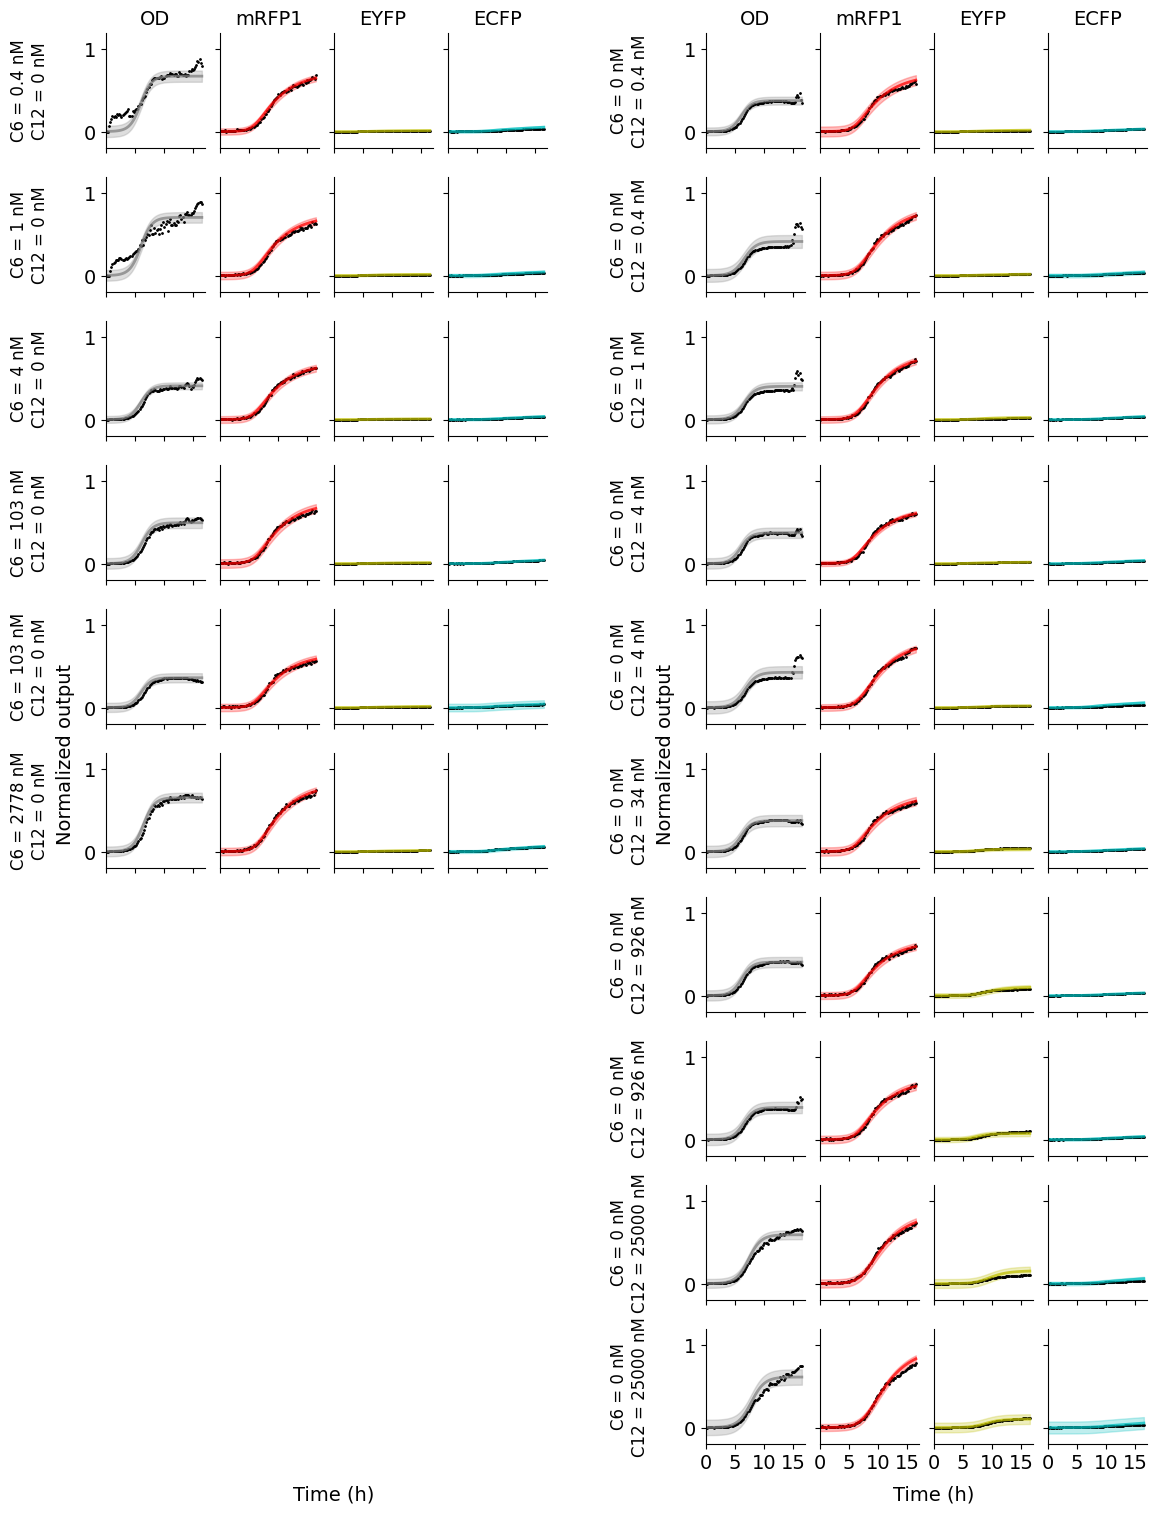

In [53]:
# Estimates of the measured signals for a specific individual
# The quantities C6 and C12 equal the concentration of the receptive proteins, 
# which are activated to enform the fluorescent compounds
Image(filename=f"{root}/xval_individual_Pcat_Y81C76.png") 

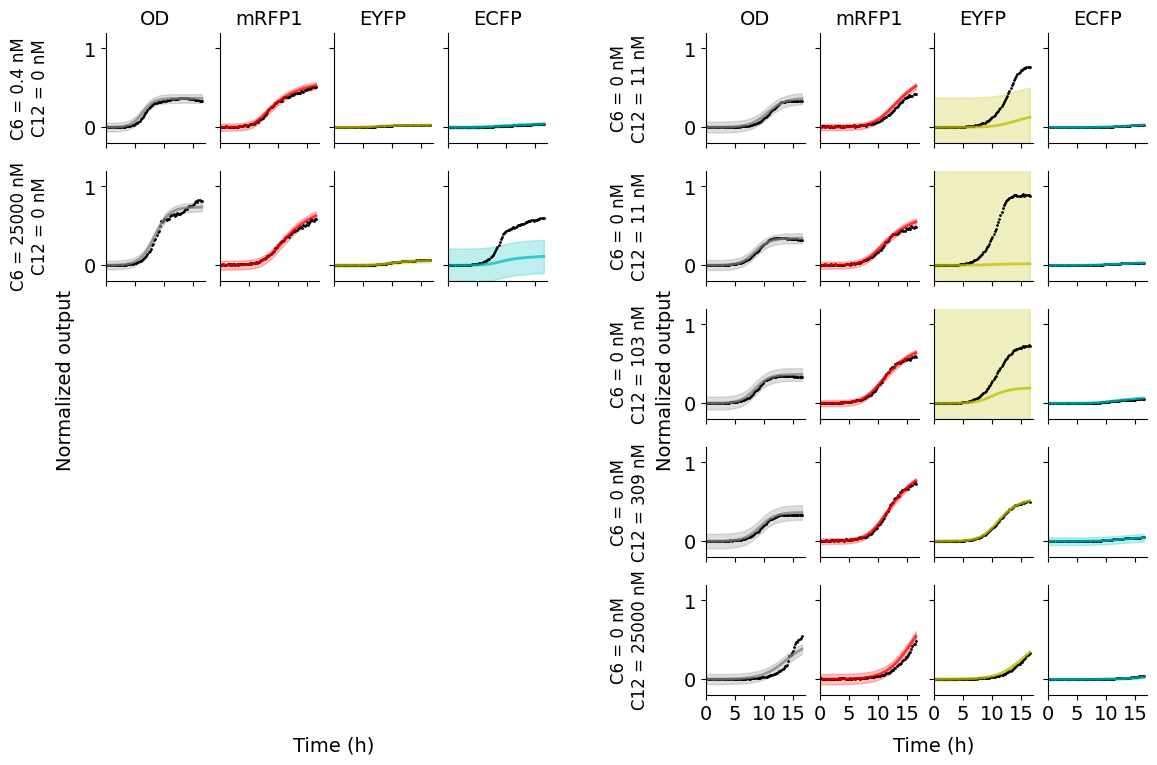

In [54]:
Image(filename=f"{root}/xval_individual_R33S34_Y81C76.png")

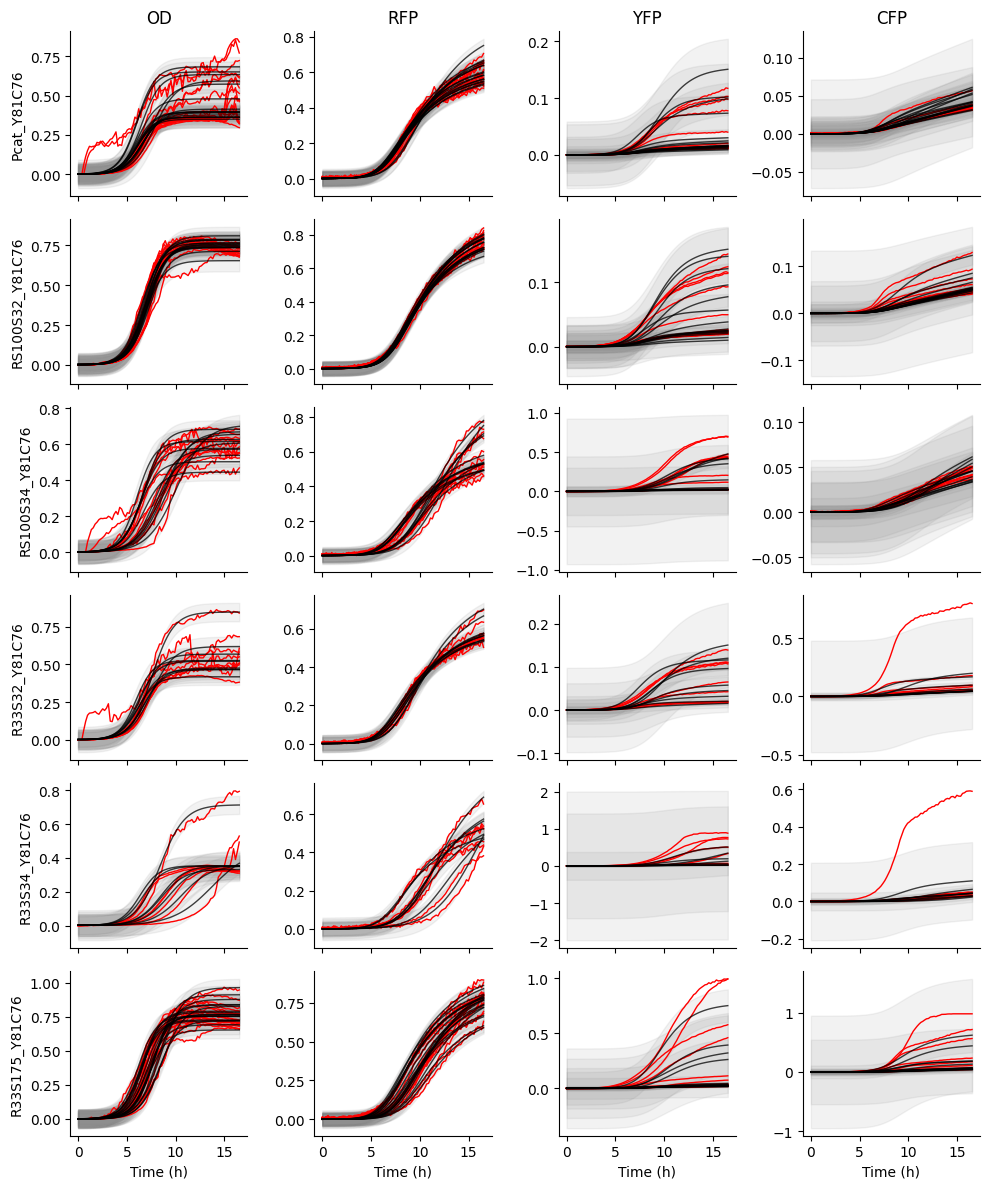

In [58]:
Image(filename=f"{root}/xval_fit.png") 

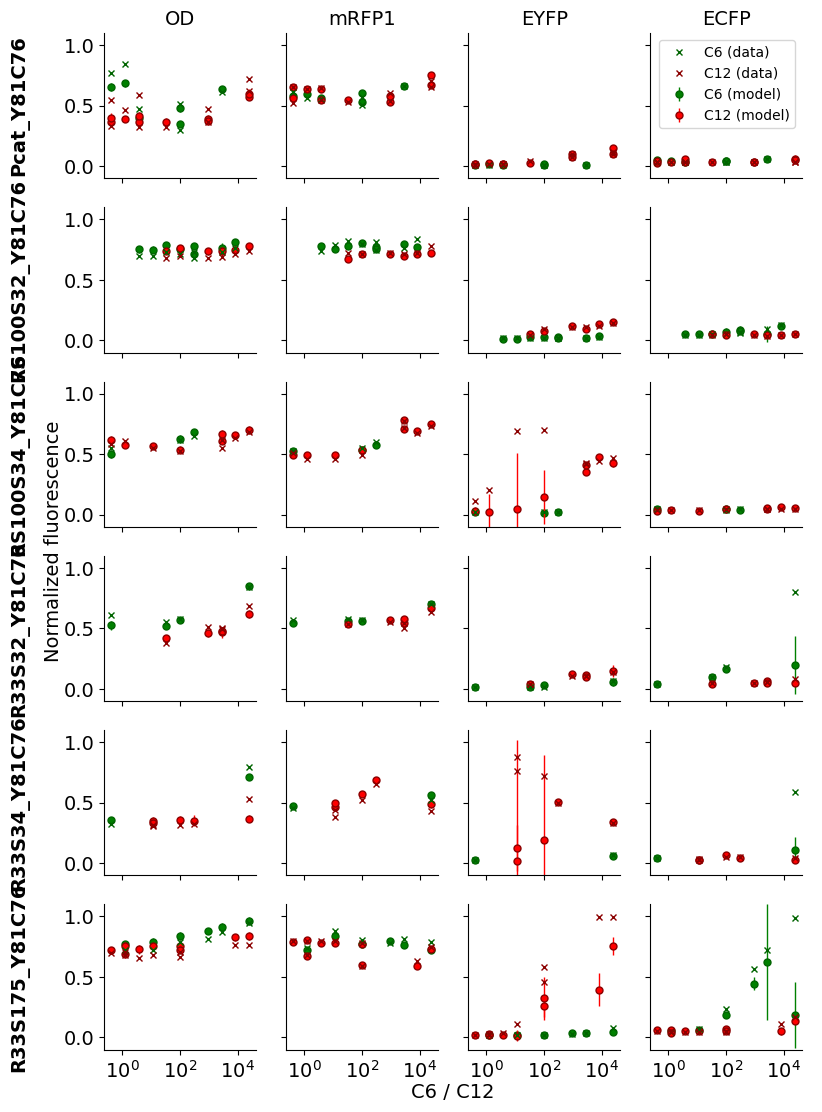

In [60]:
Image(filename=f"{root}/xval_treatments.png") 